In [1]:
import datetime
import pathlib

import numpy
import parcels
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D
import xarray

from parcels import logger, XarrayDecodedFilter

logger.addFilter(XarrayDecodedFilter())  # Add a filter for the xarray decoding warning

# Subset, lower left corner of my grid
enatl_data_path = pathlib.Path("day_1_5")

u_files = sorted(enatl_data_path.glob("*1d_vozocrtx*"))
v_files = sorted(enatl_data_path.glob("*1d_vomecrty*"))
w_files = sorted(enatl_data_path.glob("*1d_vovecrtz*"))

assert len(u_files) == len(w_files)
assert len(u_files) == len(v_files)

enatl_mesh_mask_file = enatl_data_path / "mesh_mask_eNATL60FARSHE_3.6.nc"

In [2]:
filenames = {
    "U": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": u_files[2:],
    },
    "V": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": v_files[2:],
    },
    "W": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": w_files[2:],
    },
}

variables = {
    "U": "vozocrtx",
    "V": "vomecrty",
    "W": "vovecrtz",
}

dimensions = {
    "U": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "V": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "W": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
}

In [3]:
fieldset_second_half = FieldSet.from_nemo(filenames, variables, dimensions)

In [4]:
endtime = datetime.datetime(2010, 1, 3, 12)
starttime = endtime + datetime.timedelta(days=2)

runtime = endtime - starttime
dt = datetime.timedelta(hours=6)

In [5]:
if runtime < datetime.timedelta(minutes=0):
    dt = -dt
    runtime = -runtime

In [6]:
runtime

datetime.timedelta(days=2)

In [7]:
dt

datetime.timedelta(days=-1, seconds=64800)

In [8]:
start_point = (-7.883789, 60.239120)  # y_c = 9, x_r = 21
stop_point = (-7.857898, 60.327419)  # y_c = 18, x_r = 21
depth = 52.48403405  # z_c = 20

pset = ParticleSet.from_line(
    fieldset=fieldset_second_half,
    pclass=JITParticle,
    size=10,
    start=start_point,
    finish=stop_point,
    depth=depth,
    time=starttime,
)
output_file = pset.ParticleFile(
    name="output_backward_interrupted_mode.zarr", outputdt=datetime.timedelta(hours=6)
)
kernels = pset.Kernel(AdvectionRK4_3D)


def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [9]:
pset.execute(
    kernels,
    runtime=runtime,
    dt=dt,
    output_file=output_file,
    recovery={parcels.ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/kk/m6gqzmx50nxfthwxklx9dr640000gp/T/parcels-502/lib2bb9a4dee7eebafc54bac9047b6314dc_0.so


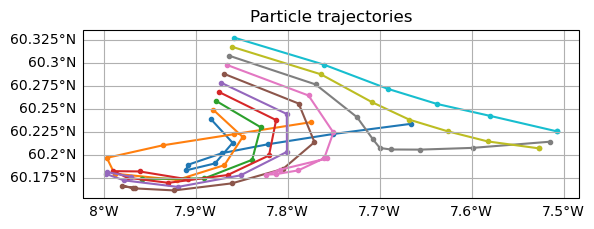

<module 'matplotlib.pyplot' from '/Users/niten/.local/anaconda/envs/opt-m1-lagrangian/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [10]:
parcels.plotTrajectoriesFile("output_backward_interrupted_mode.zarr")

In [11]:
endtime = datetime.datetime(2010, 1, 1, 12)
starttime = endtime + datetime.timedelta(days=2)

filenames_first_half = {
    "U": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": u_files[:3],
    },
    "V": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": v_files[:3],
    },
    "W": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": w_files[:3],
    },
}

fieldset_first_half = FieldSet.from_nemo(filenames_first_half, variables, dimensions)
pset = ParticleSet.from_particlefile(
    fieldset=fieldset_first_half,
    pclass=JITParticle,
    filename="output_backward_interrupted_mode.zarr",
    restart=True,
    restarttime=numpy.nanmin,
)
output_file = pset.ParticleFile(
    name="output_backward_continued_mode.zarr", outputdt=datetime.timedelta(hours=6)
)
kernels = pset.Kernel(AdvectionRK4_3D)

In [12]:
pset.execute(
    kernels,
    runtime=runtime,
    dt=dt,
    output_file=output_file,
    recovery={parcels.ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/kk/m6gqzmx50nxfthwxklx9dr640000gp/T/parcels-502/libe5f69f7f35b5e1f34cc4ad662863b9ca_0.so


ValueError: cannot reindex or align along dimension 'trajectory' because the (pandas) index has duplicate values

In [ ]:
parcels.plotTrajectoriesFile("output_backward_continued_mode.zarr")

In [ ]:
particles = xarray.open_zarr("output_backward_interrupted_mode.zarr")

In [ ]:
particles